In [15]:
%pip install -r requirements.txt


[notice] A new release of pip is available: 26.0 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [16]:
from pathlib import Path
import pandas as pd

DATA_DIR = Path("data")
csv_files = sorted(DATA_DIR.glob("*.csv"))

if not csv_files:
    raise FileNotFoundError(f"No CSV files found in {DATA_DIR.resolve()}")

df = pd.concat((pd.read_csv(path) for path in csv_files), ignore_index=True)
df.head()

,timestamp,impl,op,load_factor,metric,value,unit,tag
0,2026-02-20T11:29:55.170753+00:00,m0_hashbrown,insert_marginal,0.50,mean,2.690377e+03,ns,testing1
1,2026-02-20T11:29:55.170753+00:00,m0_hashbrown,insert_marginal,0.50,median,2.828549e+03,ns,testing1
2,2026-02-20T11:29:55.170753+00:00,m0_hashbrown,insert_marginal,0.50,std_dev,7.141874e+02,ns,testing1
3,2026-02-20T11:29:55.170753+00:00,m0_hashbrown,insert_marginal,0.50,throughput_ops_per_sec,4.757697e+07,ops/s,testing1
4,2026-02-20T11:29:55.170753+00:00,m0_hashbrown,insert_marginal,0.75,mean,2.564954e+03,ns,testing1


In [17]:
# Benchmark data shape (comparison-ready)
# Keep this summary stable as new implementations arrive so we can compare apples-to-apples.

comparison_dims = ["impl", "op", "load_factor", "metric", "unit", "tag"]
missing_dims = [c for c in comparison_dims if c not in df.columns]
if missing_dims:
    raise ValueError(f"Missing comparison columns: {missing_dims}")

# Normalize type to avoid accidental mismatches across future CSVs (e.g., 0.5 vs "0.50")
df_cmp = df.copy()
df_cmp["load_factor"] = pd.to_numeric(df_cmp["load_factor"], errors="coerce").round(4)

print("Rows x columns:", df_cmp.shape)
print("\nColumns:", list(df_cmp.columns))

print("\nUnique counts per comparison dimension:")
display(df_cmp[comparison_dims].nunique().rename("unique_values").to_frame())

print("\nCoverage by implementation and operation:")
coverage = (
    df_cmp.groupby(["impl", "op"], dropna=False)
    .size()
    .rename("rows")
    .reset_index()
    .sort_values(["impl", "op"])
)
display(coverage)

print("\nApples-to-apples panel shape (impl x shared benchmark points):")
benchmark_key = ["op", "load_factor", "metric", "unit", "tag"]
panel = (
    df_cmp.groupby(["impl", *benchmark_key], dropna=False)
    .agg(value_mean=("value", "mean"), n=("value", "size"))
    .reset_index()
)
display(panel.head(20))
print("Panel rows:", len(panel))

Rows x columns: (360, 8)

Columns: ['timestamp', 'impl', 'op', 'load_factor', 'metric', 'value', 'unit', 'tag']

Unique counts per comparison dimension:


,unique_values
impl,2
op,3
load_factor,5
metric,4
unit,2
tag,5



Coverage by implementation and operation:


,impl,op,rows
0,m0_hashbrown,insert_marginal,60
1,m0_hashbrown,lookup_hit,60
2,m0_hashbrown,lookup_miss,60
3,radix_tree,insert_marginal,60
4,radix_tree,lookup_hit,60
5,radix_tree,lookup_miss,60



Apples-to-apples panel shape (impl x shared benchmark points):


,impl,op,load_factor,metric,unit,tag,value_mean,n
0,m0_hashbrown,insert_marginal,0.50,mean,ns,enter radix,2.266614e+03,1
1,m0_hashbrown,insert_marginal,0.50,mean,ns,testing1,2.478495e+03,2
2,m0_hashbrown,insert_marginal,0.50,median,ns,enter radix,2.441595e+03,1
3,m0_hashbrown,insert_marginal,0.50,median,ns,testing1,2.635072e+03,2
4,m0_hashbrown,insert_marginal,0.50,std_dev,ns,enter radix,6.702156e+02,1
5,m0_hashbrown,insert_marginal,0.50,std_dev,ns,testing1,6.922015e+02,2
6,m0_hashbrown,insert_marginal,0.50,throughput_ops_per_sec,ops/s,enter radix,5.647191e+07,1
7,m0_hashbrown,insert_marginal,0.50,throughput_ops_per_sec,ops/s,testing1,5.202444e+07,2
8,m0_hashbrown,insert_marginal,0.75,mean,ns,enter radix,2.381682e+03,1
9,m0_hashbrown,insert_marginal,0.75,mean,ns,testing1,2.473318e+03,2


Panel rows: 300


Missing combinations found:


,op,load_factor,metric,unit,tag,impl
4,insert_marginal,0.50,mean,ns,radix take 1,m0_hashbrown
6,insert_marginal,0.50,mean,ns,Introducing SIMD,m0_hashbrown
8,insert_marginal,0.50,mean,ns,Introducing SIMD 2,m0_hashbrown
14,insert_marginal,0.75,mean,ns,radix take 1,m0_hashbrown
16,insert_marginal,0.75,mean,ns,Introducing SIMD,m0_hashbrown
...,...,...,...,...,...,...
573,lookup_miss,0.90,throughput_ops_per_sec,ops/s,enter radix,radix_tree
581,lookup_miss,0.95,throughput_ops_per_sec,ops/s,testing1,radix_tree
583,lookup_miss,0.95,throughput_ops_per_sec,ops/s,enter radix,radix_tree
591,lookup_miss,0.99,throughput_ops_per_sec,ops/s,testing1,radix_tree


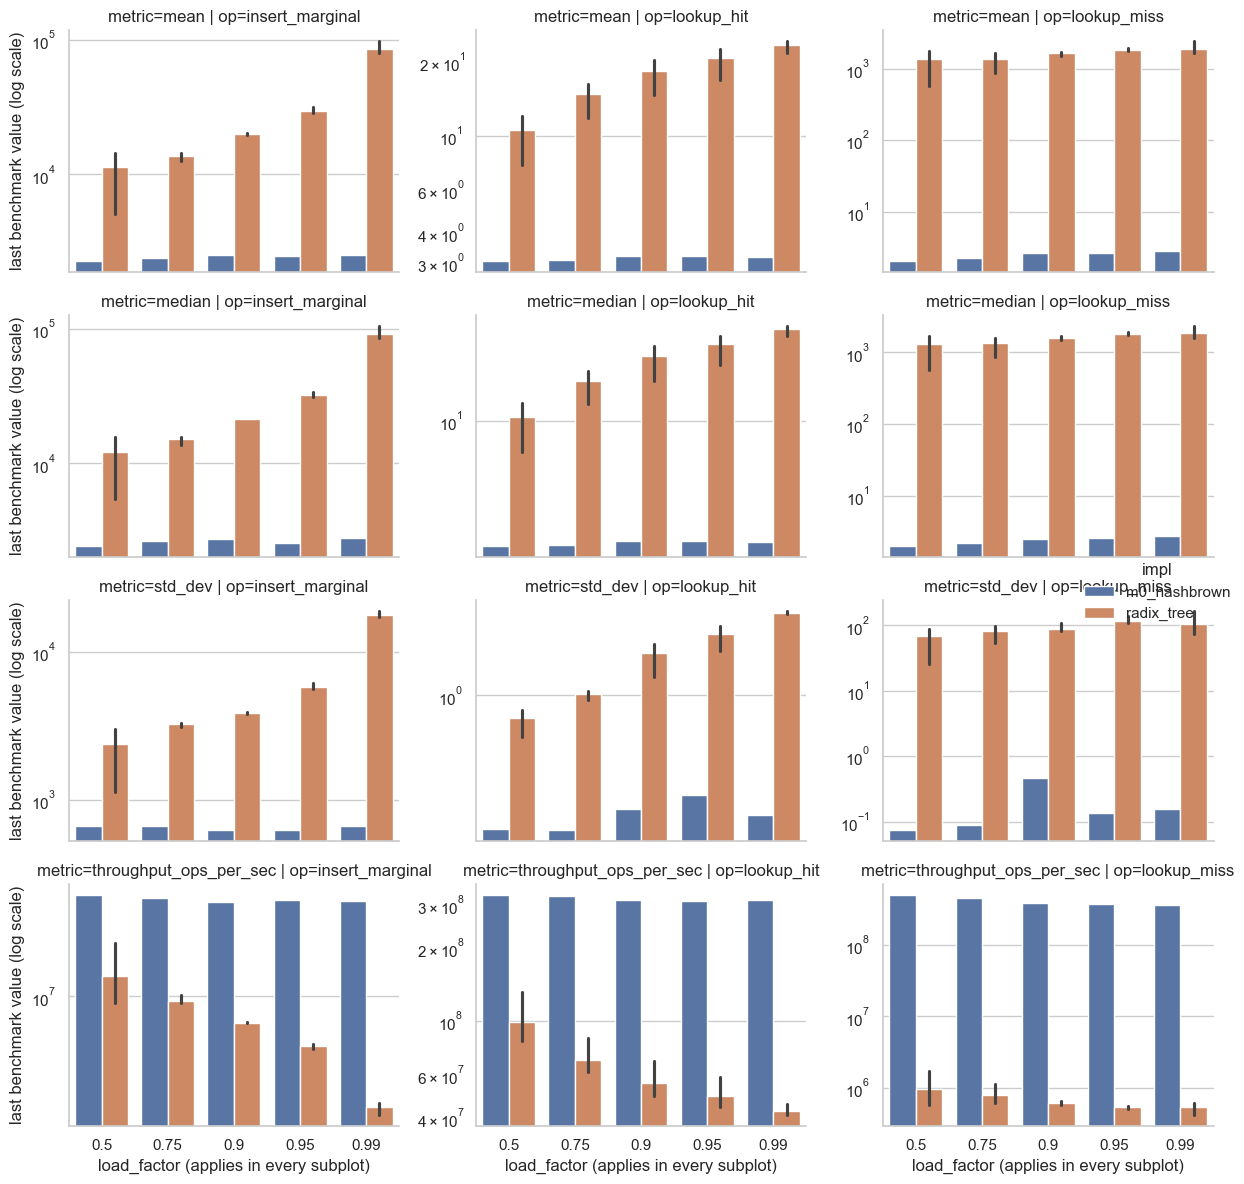

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", context="notebook")

required_cols = ["timestamp", "impl", "op", "load_factor", "metric", "unit", "tag", "value"]
missing_cols = [c for c in required_cols if c not in df_cmp.columns]
if missing_cols:
    raise ValueError(f"Missing columns needed for plotting: {missing_cols}")

# Keep only the latest result per unique benchmark test key.
# Test key = impl + op + load_factor + metric + unit + tag
plot_df = df_cmp.copy()
plot_df["timestamp"] = pd.to_datetime(plot_df["timestamp"], utc=True, errors="coerce")

last_values = (
    plot_df.sort_values(["timestamp", "impl", "op", "load_factor", "metric", "unit", "tag"])
    .drop_duplicates(["impl", "op", "load_factor", "metric", "unit", "tag"], keep="last")
    .sort_values(["metric", "op", "load_factor", "impl"])
)

# display(
#     last_values[["timestamp", "impl", "op", "load_factor", "metric", "unit", "tag", "value"]]
# )

# Quick completeness check against the full apples-to-apples key (without impl)
all_points = last_values[["op", "load_factor", "metric", "unit", "tag"]].drop_duplicates()
missing_report = (
    all_points.assign(_key=1)
    .merge(last_values[["impl"]].drop_duplicates().assign(_key=1), on="_key", how="outer")
    .drop(columns="_key")
    .merge(
        last_values[["impl", "op", "load_factor", "metric", "unit", "tag"]].assign(present=1),
        on=["impl", "op", "load_factor", "metric", "unit", "tag"],
        how="left",
    )
)

missing_only = missing_report[missing_report["present"].isna()].drop(columns="present")
if missing_only.empty:
    print("No missing impl/op/load_factor/metric/unit/tag combinations in latest data.")
else:
    print("Missing combinations found:")
    display(missing_only.sort_values(["impl", "op", "metric", "load_factor"]))

# Column charts by operation (columns) and metric (rows).
# Log y-scale prevents one impl from visually disappearing when values differ by orders of magnitude.
g = sns.catplot(
    data=last_values,
    kind="bar",
    x="load_factor",
    y="value",
    hue="impl",
    col="op",
    row="metric",
    sharey=False,
    height=3,
    aspect=1.2,
)

g.set(yscale="log")
g.set_axis_labels("load_factor (applies in every subplot)", "last benchmark value (log scale)")
g.set_titles(row_template="metric={row_name}", col_template="op={col_name}")
plt.tight_layout()
plt.show()

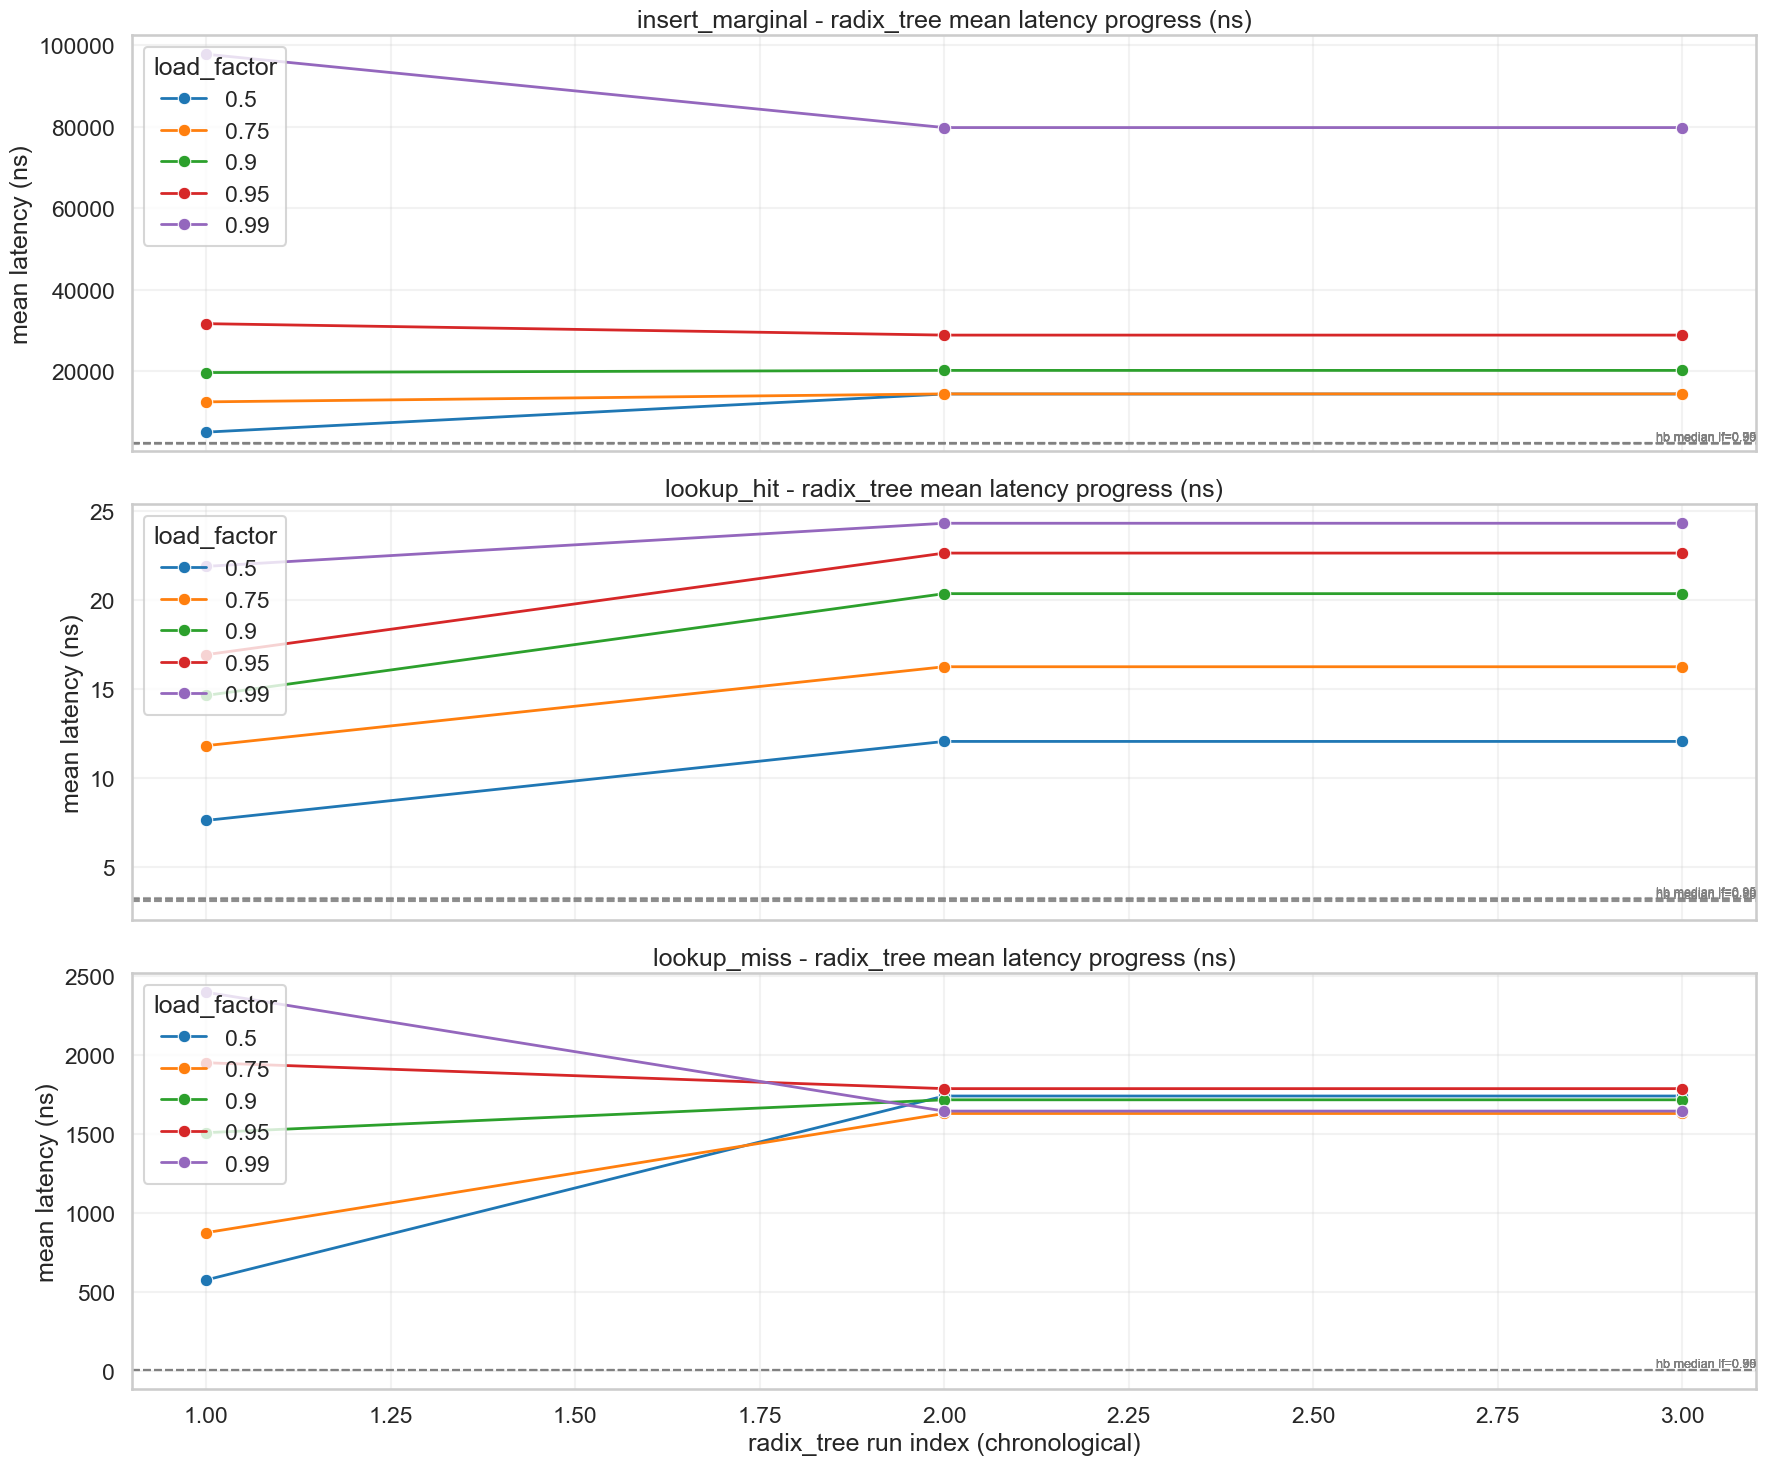

,impl,timestamp,tag,run_idx
180,radix_tree,2026-02-22 10:40:15.127746+00:00,radix take 1,1
240,radix_tree,2026-02-22 11:10:49.575216+00:00,Introducing SIMD,2
300,radix_tree,2026-02-22 11:17:38.113651+00:00,Introducing SIMD 2,3


In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", context="talk")

# Track optimization progress for radix_tree using mean latency only.
required_cols = ["timestamp", "impl", "op", "load_factor", "metric", "unit", "value", "tag"]
missing_cols = [c for c in required_cols if c not in df_cmp.columns]
if missing_cols:
    raise ValueError(f"Missing columns needed for progress charts: {missing_cols}")

plot_src = df_cmp.copy()
plot_src["timestamp"] = pd.to_datetime(plot_src["timestamp"], utc=True, errors="coerce")
plot_src["load_factor"] = pd.to_numeric(plot_src["load_factor"], errors="coerce")

# Focus only on mean latency (ns); ignore median/std_dev/throughput for now.
mean_ns = plot_src[(plot_src["metric"] == "mean") & (plot_src["unit"] == "ns")].copy()

# A benchmark run is identified by implementation + timestamp + tag.
run_meta = (
    mean_ns[["impl", "timestamp", "tag"]]
    .drop_duplicates()
    .sort_values(["impl", "timestamp", "tag"])
)
run_meta["run_idx"] = run_meta.groupby("impl").cumcount() + 1

mean_ns = mean_ns.merge(run_meta, on=["impl", "timestamp", "tag"], how="left")

radix = mean_ns[mean_ns["impl"] == "radix_tree"].copy()
hashbrown = mean_ns[mean_ns["impl"] == "m0_hashbrown"].copy()

if radix.empty:
    raise ValueError("No radix_tree mean/ns data found.")
if hashbrown.empty:
    raise ValueError("No m0_hashbrown mean/ns data found for reference lines.")

# Hashbrown reference = median value across its runs for each (op, load_factor).
hb_ref = (
    hashbrown.groupby(["op", "load_factor"], as_index=False)["value"]
    .median()
    .rename(columns={"value": "hb_median_ns"})
)

ops_order = ["insert_marginal", "lookup_hit", "lookup_miss"]
ops_present = [op for op in ops_order if op in radix["op"].unique()]
if not ops_present:
    raise ValueError("No target ops found for radix_tree.")

fig, axes = plt.subplots(len(ops_present), 1, figsize=(18, 5 * len(ops_present)), sharex=True)
if len(ops_present) == 1:
    axes = [axes]

palette = sns.color_palette("tab10", n_colors=max(1, radix["load_factor"].nunique()))

for ax, op in zip(axes, ops_present):
    op_radix = radix[radix["op"] == op].sort_values(["load_factor", "run_idx"])

    sns.lineplot(
        data=op_radix,
        x="run_idx",
        y="value",
        hue="load_factor",
        marker="o",
        linewidth=2,
        palette=palette,
        ax=ax,
    )

    # Overlay hashbrown median reference line per load_factor (not a time series).
    op_ref = hb_ref[hb_ref["op"] == op]
    for _, row in op_ref.iterrows():
        lf = row["load_factor"]
        y = row["hb_median_ns"]
        ax.axhline(y=y, linestyle="--", linewidth=1.5, color="gray", alpha=0.65)
        ax.text(
            x=ax.get_xlim()[1] if len(op_radix) else 1,
            y=y,
            s=f"hb median lf={lf:.2f}",
            va="bottom",
            ha="right",
            fontsize=9,
            color="gray",
        )

    ax.set_title(f"{op} - radix_tree mean latency progress (ns)")
    ax.set_ylabel("mean latency (ns)")
    ax.grid(True, alpha=0.25)

axes[-1].set_xlabel("radix_tree run index (chronological)")

# Keep one legend per axis because load_factor meaning is op-specific in each subplot.
for ax in axes:
    ax.legend(title="load_factor", loc="upper left", frameon=True)

plt.tight_layout()
plt.show()

# Optional helper table: run index mapping for traceability.
display(run_meta[run_meta["impl"] == "radix_tree"].sort_values("run_idx"))